In [1]:
!pip install ipympl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Widget to manipulate plots in Jupyter notebooks
%matplotlib widget 

import matplotlib.pyplot as plt # For general plotting
import matplotlib.colors as mcol

import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal as mvn
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_spd_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.nn.functional as F

# Utility to visualize PyTorch network and shapes
from torchsummary import summary
from google.colab import output
output.enable_custom_widget_manager()

np.random.seed(2)

n = 10
n_train = 50
n_test = 1000

In [3]:
a = (np.random.rand(n, 1) * 10 - 10)
mu = np.random.rand(n) * 10 - 10
sigma = make_spd_matrix(10) * 10 #positive definite matrix
scale = 1.25

X_train = np.random.multivariate_normal(mu, sigma, n_train)
z_train = np.random.multivariate_normal(np.zeros(10), scale * np.eye(10), size=n_train)
v_train = np.random.normal(0, 1, size=n_train).reshape(-1, 1)
y_train = (X_train + z_train).dot(a) + v_train

X_test = np.random.multivariate_normal(mu, sigma, n_test)
z_test = np.random.multivariate_normal(
    np.zeros(n), scale * np.eye(n), size=n_test
)
v_test = np.random.normal(0, 1, size=n_test).reshape(-1, 1)
y_test = (X_test + z_test).dot(a) + v_test

In [4]:
def map_solution(X, y, beta=1):
    # Model: y = phi(X)^T*theta
    # LS estimate: theta^* = (phi(X)^T*phi(X))^-1 * phi(X)^T * y
    
    iden = np.identity(X.shape[1])
    class_prior = np.dot(beta,iden)
    
    return np.linalg.inv(X.T.dot(X) + class_prior).dot(X.T).dot(y)

In [5]:
k_fold = KFold(n_splits=5, shuffle=True, random_state=0) #5 folds of data;
def cross_val(b, X, y):

  err_per_k = []
  for train_idx, kf_idx in k_fold.split(X):

    X_train = X[train_idx]
    y_train = y[train_idx]
    X_k = X[kf_idx]
    y_k = y[kf_idx]

    best_theta = map_solution(X[train_idx], y_train, b)
    y_train_k_pred = X_train.dot(best_theta)        
    y_valid_k_pred = X_k.dot(best_theta)
    
    #error_m_k = mean_squared_error( y_train, y_train_k_pred)
    error_m_k = mean_squared_error(y_k, y_valid_k_pred )

    err_per_k.append(error_m_k)

  mean_err = np.mean(err_per_k)
  return mean_err

In [6]:
beta_vals = np.logspace(-2, 4)
mse_list = [cross_val(b, X_train, y_train) for b in beta_vals]
best_beta = beta_vals[np.argmin(mse_list)]

print(f"Best beta value: {best_beta}")
mse_cv = np.min(mse_list)
print(f"MSE(cross validated) of best beta: {mse_cv}")

Best beta value: 0.01
MSE(cross validated) of best beta: 430.52820516714974


In [7]:
#!pip install matplotlib==2.2.3

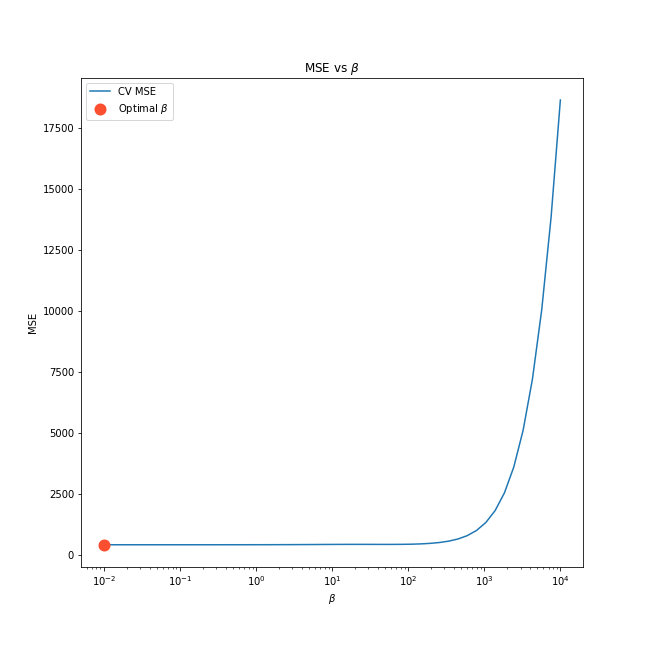

In [7]:
from google.colab import output
output.enable_custom_widget_manager()

fig, ax = plt.subplots(figsize=(9, 9))
ax.plot(beta_vals, mse_list, label="CV MSE")
ax.scatter(best_beta,np.min(mse_list),label=r"Optimal $\beta$",zorder=3,linewidth=6,color="#fc4f30")
ax.set_title(r"MSE vs $\beta$")
ax.set_xlabel(r"$\beta$")
ax.set_ylabel(r"MSE")
ax.legend()
ax.set_xscale("log")